In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset  # Dataset是个抽象类，只能用于继承
from torch.utils.data import DataLoader # DataLoader需实例化，用于加载数据
from sklearn.model_selection import train_test_split

import math
from tqdm import tqdm
from itertools import islice

# 超参数

In [3]:
class ModelConfig(object):
    """配置类，用于存储超参数的配置。
    """
    def __init__(self):
        # embedding参数
        
        # transformer模型参数
        self.d_model = 512
        self.nhead = 8
        self.num_encoder_layers = 6
        self.num_decoder_layers = 6
        self.dim_feedforward = 2048
        self.dropout = 0.1
        self.activation = 'relu'
        self.custom_encoder 
        self.custom_decoder 

In [21]:
# 超参数
SRC_LEN = 8
LABEL_LEN = 3
PRED_LEN = 1

BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据加载

In [4]:
def get_processed_data():
    data_path = 'D:/workspace/PROJECTS/天文台视宁度预测项目/data/data_v1/AllData_V1/normalized_data.csv'
    data = pd.read_csv(data_path).drop('time', axis=1)
    return data

In [5]:
def get_seq_info():
    seq_info_path = 'D:/workspace/PROJECTS/天文台视宁度预测项目/data/data_v1/AllData_V1/seq_info.csv'
    seq_info = pd.read_csv(seq_info_path)
    # 纠错
    seq_info.loc[:,'seq_len'] = seq_info.loc[:,'seq_len']+1
    seq_info = seq_info.shift(1)
    seq_info.loc[0,'seq_len']=0
    for i in range(1, seq_info.shape[0]):
        seq_info.loc[i,'seq_len'] += seq_info.loc[i-1,'seq_len']
    # 制作范围表
    seq_info = seq_info[['seq_len']]
    seq_info = seq_info.rename(columns={'seq_len':'start_idx'})
    seq_info['end_idx'] = seq_info.shift(-1)
    seq_info.iloc[-1,1]=-1
    seq_info = seq_info.applymap(lambda x:int(x))
    return seq_info

In [6]:
def get_padding_mask(data, padding_len):
    data_len = data.shape[0]
    data_dim = data.shape[1]
    if data_len < padding_len:
        # padding mask
        padding_mask = np.ones(padding_len)
        padding_mask[-data_len:]=0   # 前面padding
        # padding data
        data2 = np.zeros((padding_len, data_dim))
        data2[-data_len:,:] = data
        data2 = pd.DataFrame(data2, columns=data.columns)
    else:
        padding_mask = np.zeros(data_len)
        data2 = data
    return data2, padding_mask

In [7]:
class Dataset_normalized_data(Dataset):
    def __init__(self, data, src_len, label_len, pred_len=PRED_LEN):
        self.data = data
        self.src_len = src_len   # encoder输入序列长度
        self.label_len = label_len  # src与tgt交叉部分的长度
        self.pred_len = pred_len  # 要预测序列的长度
        
        self.tgt_len = self.label_len + self.pred_len  # decoder输入序列长度
        self.total_len = self.src_len + self.pred_len  # 整体模型输入序列的长度
        
        assert self.data.shape[0] >= self.tgt_len
        self.data, self.padding_mask = get_padding_mask(self.data, self.total_len)
        
        self.data_len = self.data.shape[0]   # 数据总长度
        self.index_len = self.data_len - self.total_len + 1  # 数据加载器的索引长度
        
        self.data_x = self.data.drop('ccd_avg', axis=1).values

        self.data_y = self.data[['ccd_avg']].values

    def __getitem__(self, index):
        src_begin = index
        src_end = src_begin + self.src_len
        
        tgt_begin = src_end - self.tgt_len
        tgt_end = src_end
        
        y_true_begin = src_end - self.label_len
        y_true_end = y_true_begin + self.tgt_len
        
        src_x = self.data_x[src_begin:src_end, :]
        src_y = self.data_y[src_begin:src_end, :]
        src_key_padding_mask = self.padding_mask[src_begin:src_end]
        
        tgt_x = self.data_x[tgt_begin:tgt_end, :]
        tgt_y = self.data_y[tgt_begin:tgt_end, :]
        tgt_key_padding_mask = self.padding_mask[tgt_begin:tgt_end].copy()
        
#         tgt_key_padding_mask[-self.pred_len:]=1  # 遮蔽掉要预测的序列，为什么一遮蔽模型就输出nan？

        y_true = self.data_y[y_true_begin: y_true_end]

        src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask, y_true = \
        [torch.Tensor(d) for d in [src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask, y_true]]
        
        return src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask, y_true
    
    def __len__(self):
        return self.index_len

In [8]:
def data_loader():
    data = get_processed_data()
    seq_info = get_seq_info()
    for idx in range(seq_info.shape[0]):
        start_idx = seq_info.iloc[idx,0]
        end_idx = seq_info.iloc[idx,1]
        seq_data = data.iloc[start_idx:end_idx, :]

        dataset = Dataset_normalized_data(data=seq_data, src_len=SRC_LEN, label_len=LABEL_LEN)
        data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=False)

        for src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask, y_true in data_loader:
            yield src_x.transpose(0, 1), src_y.transpose(0, 1), src_key_padding_mask, tgt_x.transpose(0, 1), tgt_y.transpose(0, 1), tgt_key_padding_mask, y_true.transpose(0, 1)

def train_data_loader():
    for data in islice(data_loader, 0, int(1430*.8)):
        yield data
        
def eval_data_loader():
    for data in islice(data_loader, int(1430*.8), 1430):
        yield data

data_loader = data_loader()
# data_loader_len = sum(1 for _ in data_loader)
# data_loader = data_loader()

train_data_loader = train_data_loader()
eval_data_loader = eval_data_loader()

# 位置编码

位置编码前要做归一化，否则捕获不到位置信息

## 位置编码

In [15]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:x.size(0), :]  # (seq_len, batch_size, d_model)
                                        # 这里的batch_size=1，后面做加法时可以广播

## 事件属性编码

这是我自己想的，不严谨  
后续还得看二维序列特征编码Intra and Inter-Case Features in Predictive Process Monitoring: A Tale of Two Dimensions

顺便也看看：Complex Symbolic Sequence Encodings for Predictive Monitoring of Business Processes


若是想学informer那样加一个全局事件编码，还得再写一个类

In [16]:
class FeatureEmbedding(nn.Module):
    def __init__(self, x_dim, d_model):
        super(FeatureEmbedding, self).__init__()
        
        self.Embed = nn.Linear(x_dim, d_model)
    
    def forward(self, x):
        
        x = self.Embed(x)
        return x  # (seq_len, batch_size, d_model)

## 总的数据编码

In [12]:
class DataEmbedding(nn.Module):
    def __init__(self, x_dim, d_model, dropout=0.1):
        super(DataEmbedding, self).__init__()
        
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.feature_embedding = FeatureEmbedding(x_dim, d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, y):
        res = self.position_embedding(x) + self.feature_embedding(x) + y
        return self.dropout(res)  # (seq_len， batch_size, d_model)

# 模型

# 自己造数据

In [8]:
src_y=np.random.randn(128)
src_y=torch.tensor(src_y.reshape([8,16, 1])).to(device)
print(src_y.shape)

src_key_padding_mask=np.random.randn(128)
src_key_padding_mask=torch.tensor(src_key_padding_mask.reshape([16,8])).to(device)
print(src_key_padding_mask.shape)




tgt_y=np.random.randn(64)
tgt_y=torch.tensor(tgt_y.reshape([4,16, 1])).to(device)
print(tgt_y.shape)


tgt_key_padding_mask=np.random.randn(64)
tgt_key_padding_mask=torch.tensor(tgt_key_padding_mask.reshape([16,4])).to(device)
print(tgt_key_padding_mask.shape)

y_true=np.random.randn(64)
y_true=torch.tensor(y_true.reshape([4,16, 1])).to(device)
print(y_true.shape)

torch.Size([8, 16, 1])
torch.Size([16, 8])
torch.Size([4, 16, 1])
torch.Size([16, 4])
torch.Size([4, 16, 1])


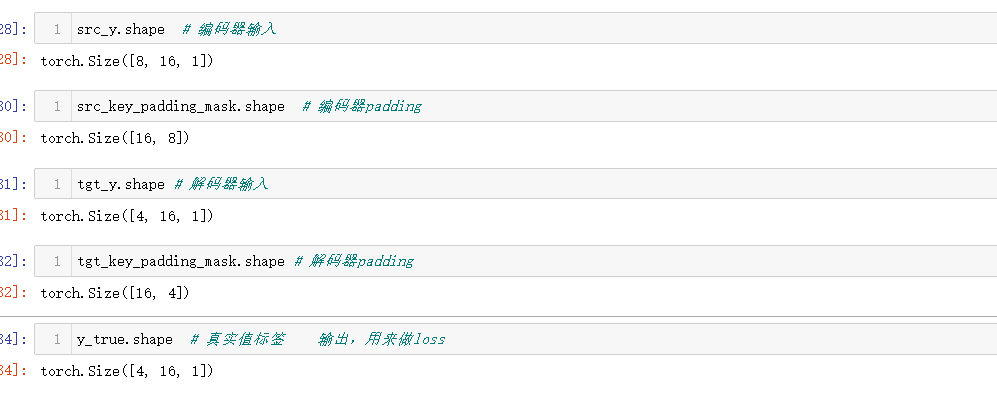

研究一下人家代码里的不认识的操作，比如：  
self.model_type = 'Transformer'  
def init_weights

再搜一个全面的案例看看

## v1模型（解码器是attention结构）

In [9]:
class ClassicTransformerModel_v1(nn.Module):
    def __init__(self, d_model=512):
        super(ClassicTransformerModel_v1, self).__init__()
        self.model_type = 'Transformer'  # 没搞明白baseline写这个有啥用
        self.src_mask = None
        # embedding
        self.enc_embedding = DataEmbedding(x_dim=50, d_model=d_model, dropout=0.1)
        self.dec_embedding = DataEmbedding(x_dim=50, d_model=d_model, dropout=0.1)
        
        # transformer
        self.transformer = torch.nn.Transformer(
            d_model=d_model, 
            nhead=8, 
            num_encoder_layers=1,
            num_decoder_layers=1, 
            dim_feedforward=2048,  # 前馈网络模型的尺寸（默认值= 2048）。
            dropout=0.1, 
            activation='relu',  # relu or gelu (default=relu).
            custom_encoder=None,  # 定制编码器
            custom_decoder=None
        )
        
        # output linear
        self.outputLinear = nn.Linear(d_model, 1)

    def forward(self, src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask):
        src_key_padding_mask = src_key_padding_mask.bool()
        tgt_key_padding_mask = tgt_key_padding_mask.bool()

        src = self.enc_embedding(src_x, src_y)  # 位置编码
        tgt = self.dec_embedding(tgt_x, tgt_y)  # 位置编码
        output = self.transformer(src, tgt, src_key_padding_mask=None , tgt_key_padding_mask=None)
        output = self.outputLinear(output)
        return output   # (seq_len， batch_size, 1)

## v2模型（解码器为单层感知机）

In [13]:
class ClassicTransformerModel_v2(nn.Module):
    def __init__(self, d_model=512):
        super(ClassicTransformerModel_v2, self).__init__()
        self.model_type = 'Transformer'  # 没搞明白baseline写这个有啥用
        self.src_mask = None
        
        # embedding
        self.data_embedding = DataEmbedding(x_dim=50, d_model=d_model, dropout=0.1)
        
        # transformer_encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        # linear_decoder
        self.decoder = nn.Linear(d_model, 1)
        self.init_weights()
        self.src_key_padding_mask = None

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src_x, src_y, src_key_padding_mask):
        src = self.data_embedding(src_x, src_y)  # 位置编码
        src_key_padding_mask = src_key_padding_mask.bool()
        output = self.transformer_encoder(src, self.src_mask, src_key_padding_mask)
        output = self.decoder(output)
        return output

In [17]:
model = ClassicTransformerModel_v1().to(device)

# 优化器&损失函数

In [18]:
lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.MSELoss().to(device)

# 封装函数

梯度剪裁参考：https://www.cnblogs.com/lindaxin/p/7998196.html

In [36]:
def train():
    calculate_loss_over_all_values = False # 超参数
    
    model.train()  # Turn on the train mode
    total_loss = []

#     for train_data in tqdm(train_data_loader):
    optimizer.zero_grad()
    src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask, y_true = \
    [d.to(device) for d in train_data]
    targets = y_true
    output = model(src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask)

    if calculate_loss_over_all_values:
        loss = criterion(output, targets)
    else:
        loss = criterion(output[-PRED_LEN:], targets[-PRED_LEN:])

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)   # 梯度裁剪
    optimizer.step()

    total_loss.append(loss.cpu().item())
    return np.average(total_loss)

In [37]:
def evaluate():
    model.eval()
    total_loss = []
    with torch.no_grad():
#         for eval_data in tqdm(eval_data_loader):
        src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask, y_true = \
        [d.to(device) for d in eval_data]
        targets = y_true
        output = model(src_x, src_y, src_key_padding_mask, tgt_x, tgt_y, tgt_key_padding_mask)
        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-PRED_LEN:], targets[-PRED_LEN:])
        total_loss.append(loss.cpu().item())
    return np.average(total_loss)

In [40]:
def Trainer(epochs):
    train_loss_logs = []
    eval_loss_logs = []
    for epoch in range(1, epochs + 1):
        print(f'开始进行第{epoch}轮训练')
        train_loss = train()
        train_loss_logs.append(train_loss)
        print(f'train loss为{train_loss}\n')
        print(f'开始进行第{epoch}轮验证')
        eval_loss = evaluate(eval_data_loader)
        eval_loss_logs.append(eval_loss)
        print(f'eval loss为{eval_loss}')
        break
    return train_loss_logs, eval_loss_logs

# 训练

In [41]:
train_loss_logs, eval_loss_logs = Trainer(10)

开始进行第1轮训练


NameError: name 'train_data' is not defined

In [20]:
train_loss_logs

[0.5857355349246979]